In [1]:
import nltk
#nltk.download('brown')
#nltk.download('universal_tagset')
from nltk.corpus import brown

In [2]:
brown_tagged_sents = brown.tagged_sents(categories='news')
size = int(len(brown_tagged_sents) * 0.9)
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]

In [3]:
#train the tagger
unigram_tagger = nltk.UnigramTagger(train_sents)

In [4]:
#calculate the accuracy
print("Results on train set {0}".format(unigram_tagger.evaluate(train_sents)))
print("Results on test set {0}".format(unigram_tagger.evaluate(test_sents)))

Results on train set 0.9353630649241612
Results on test set 0.8121200039868434


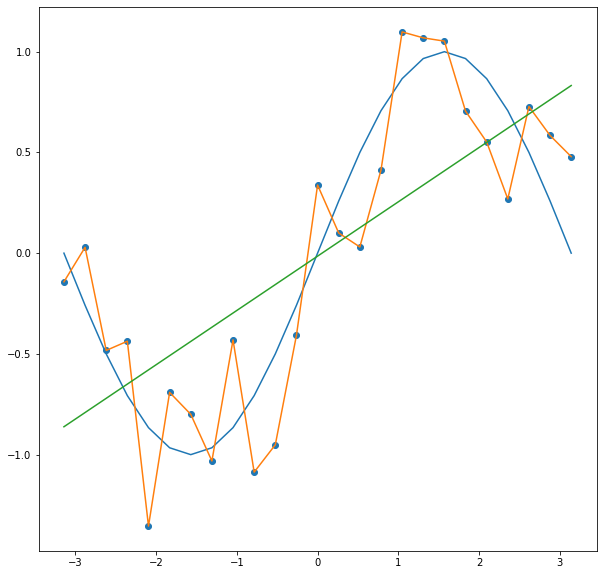

In [5]:
#1) Why is the training accuracy higher than the testing accuracy?
#  Because the model is optimized on the training data not the testing data.
#  Depends on how high and how low the training and testing accuracies are, one can determine if the model overfits or underfits.
#  The following is an simple example of overfitting and underfitting. 
#  Neither the orange nor the green line can capture the underlying structure of the dataset. 
#  The orange line has perfect (100%) training accuracy but will have high out-of-sample error.
#  The green line doesn't even fit in the training data, so it will have low accuracy on both training and testing data. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# generate y = sin(x) + noise
x = np.linspace(-np.pi, np.pi, 25)
y = np.sin(x) + np.random.uniform(-0.5,0.5, 25)
sin_line = np.sin(x)
x = x.reshape(25,1)
y = y.reshape(25,1)

# overfitting a polynomial with degree 24 which means the line passes each point for all 25 points.
degree1 = 24
polyreg=make_pipeline(PolynomialFeatures(degree1),LinearRegression())
polyreg.fit(x,y)

# underfitting a polynomial with degree 1 (linear).
degree2 = 1
linreg=make_pipeline(PolynomialFeatures(degree2),LinearRegression())
linreg.fit(x,y)

# plot the results
plt.figure(figsize = (10,10))
plt.scatter(x,y)
plt.plot(x, sin_line)
plt.plot(x, polyreg.predict(x))
plt.plot(x, linreg.predict(x))


In [6]:
#2) Why is the training accuracy not perfect (100%)
#  Training accuracy shouldn't be 100%. This means the model is overfitting and lack of gerneralization. 
#  Regularization(for example adding l1 or l2 regularization to a cost function) is a good way of preventing overfitting.
#  The following shows a detailed report using 0.85(close to test accuracy) f1-socre threshhold.
#  Because there is no backoff tagger set when the UnigramTagger cannot classify the tag for unknown word,
#  it is possible that some words are missclassified to X(other).
#  Also, PRT(particle) shows low precision and high recall, meanning some non-PRT are classified as PRT.  

# Train a different tagger with universal tagger to make the report interpretable
universal_tagged_sents = brown.tagged_sents(categories='news', tagset='universal')
size = int(len(universal_tagged_sents) * 0.9)
universal_train_sents = universal_tagged_sents[:size]
universal_test_sents = universal_tagged_sents[size:]
unigram_tagger_universal = nltk.UnigramTagger(universal_train_sents)

# print detailed results for UnigramTagger
tagged_test_sents = unigram_tagger_universal.tag_sents([[token for token,tag in sent] for sent in universal_test_sents])
new_words = [str(tag) for s in universal_test_sents for token,tag in s]
pred = [str(tag) for s in tagged_test_sents for token,tag in s]
results = metrics.classification_report(new_words, pred,output_dict=True,zero_division=0)

try:
    for key in results.keys():
        if results[key]['f1-score'] <= 0.85:
            print("{:<15} precision: {:<10} recall: {:<10} fi_score: {:<10} support: {:<10}".format(
                          str(key),
                          round(results[key]['precision'],2), 
                          round(results[key]['recall'],2), 
                          round(results[key]['f1-score'],2),
                          results[key]['support'])
                          )
except:
# skip nan value in the output jason
    pass

ADJ             precision: 0.89       recall: 0.76       fi_score: 0.82       support: 727       
ADV             precision: 0.95       recall: 0.72       fi_score: 0.82       support: 407       
NOUN            precision: 0.96       recall: 0.71       fi_score: 0.82       support: 2713      
None            precision: 0.0        recall: 0.0        fi_score: 0.0        support: 0         
PRT             precision: 0.68       recall: 0.93       fi_score: 0.78       support: 267       
X               precision: 1.0        recall: 0.05       fi_score: 0.09       support: 22        


In [7]:
def_tagger= nltk.DefaultTagger("NN")
uni_tagger=  nltk.UnigramTagger(train_sents, backoff=def_tagger)

print("Results on train set {0}".format(uni_tagger.evaluate(train_sents)))
print("Results on test set {0}".format(uni_tagger.evaluate(test_sents)))

Results on train set 0.9353630649241612
Results on test set 0.8361407355726104


In [8]:
#3) Why does the accuracy score on the training data not go up but it does on the test data?
#  Because there is a backoff tagger set to this unigram tagger. Unknown words are now set to Noun and a lot English words are noun.
#4) Create two new taggers, A BigramTagger that has not backoff and a BigramTagger that user a unigram tagger as backoff. Report the accuracies. Why is one so much lower than the other?
#  This is because one of the bigram tagger does not have a backoff tagger, 
#  So it cannot correctly classify the tags for words not seen in the training set.

uni_tagger =  nltk.UnigramTagger(train_sents)
bigram_tagger_no_backoff = nltk.BigramTagger(train_sents)
bigram_tagger_with_backoff = nltk.BigramTagger(train_sents, backoff=uni_tagger)

print("----------bigram_tagger_no_backoff----------")
print("Results on train set {0}".format(bigram_tagger_no_backoff.evaluate(train_sents)))
print("Results on test set {0}".format(bigram_tagger_no_backoff.evaluate(test_sents)))
print("---------bigram_tagger_wiht_backoff---------")
print("Results on train set {0}".format(bigram_tagger_with_backoff.evaluate(train_sents)))
print("Results on test set {0}".format(bigram_tagger_with_backoff.evaluate(test_sents)))

----------bigram_tagger_no_backoff----------
Results on train set 0.7884137382485832
Results on test set 0.10206319146815508
---------bigram_tagger_wiht_backoff---------
Results on train set 0.9736193811380784
Results on test set 0.8210904016744742


In [9]:
#5 Repeat #4 with a TrigramTagger using a Bigramtagger as backoff
tri_tagger = nltk.TrigramTagger(train_sents, backoff=bigram_tagger_with_backoff)
print("Results on train set {0}".format(tri_tagger.evaluate(train_sents)))
print("Results on test set {0}".format(tri_tagger.evaluate(test_sents)))

Results on train set 0.9829321372941086
Results on test set 0.8185986245390212


In [11]:
# Train a different trigram_tagger with universal tagger to make the report interpretable
universal_tri_tagger = nltk.TrigramTagger(universal_train_sents)

# print detailed results for UnigramTagger
tagged_test_sents = universal_tri_tagger.tag_sents([[token for token,tag in sent] for sent in universal_test_sents])
results_tri = metrics.classification_report(gold, pred,output_dict=True,zero_division=0)

try:
    for key in results_tri.keys():
        if results_tri[key]['f1-score'] <= 0.85:
            print("{:<15} precision: {:<10} recall: {:<10} fi_score: {:<10} support: {:<10}".format(
                          str(key),
                          round(results_tri[key]['precision'],2), 
                          round(results_tri[key]['recall'],2), 
                          round(results_tri[key]['f1-score'],2),
                          results_tri[key]['support'])
                          )
except:
# skip nan value in the output jason
    pass

.               precision: 1.0        recall: 0.06       fi_score: 0.11       support: 1301      
ADJ             precision: 0.95       recall: 0.07       fi_score: 0.14       support: 727       
ADP             precision: 0.96       recall: 0.09       fi_score: 0.16       support: 1291      
ADV             precision: 0.87       recall: 0.1        fi_score: 0.18       support: 407       
CONJ            precision: 1.0        recall: 0.09       fi_score: 0.17       support: 287       
DET             precision: 1.0        recall: 0.18       fi_score: 0.31       support: 1148      
NOUN            precision: 1.0        recall: 0.04       fi_score: 0.07       support: 2713      
NUM             precision: 1.0        recall: 0.09       fi_score: 0.17       support: 193       
None            precision: 0.0        recall: 0.0        fi_score: 0.0        support: 0         
PRON            precision: 1.0        recall: 0.19       fi_score: 0.32       support: 223       
PRT             prec